# Keypoint Detection

**Keypoint detection** identifies and locates specific points of interest within an image. These keypoints, also known as **landmarks**, represent meaningful features of objects, such as facial features or object parts.

The models take an image input and return the following outputs:
* **Keypoints** and **Scores**: points of interest and their confidence scores
* **Descriptors**: a representation of the image region surrounding each keypoint, capturing its texture, gradient, orientation and other properties

We will use `SuperPoint` for keypoint detection here.

In [2]:
from transformers import AutoImageProcessor, SuperPointForKeypointDetection

checkpoint = 'magic-leap-community/superpoint'
processor = AutoImageProcessor.from_pretrained(checkpoint)
model = SuperPointForKeypointDetection.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/194 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.21M [00:00<?, ?B/s]

In [3]:
# load images
import torch
from PIL import Image
import requests
import cv2

url_image_1 = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/bee.jpg"
url_image_2 = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/cats.png"
image_1 = Image.open(requests.get(url_image_1, stream=True).raw)
image_2 = Image.open(requests.get(url_image_2, stream=True).raw)
image_1 = image_1.convert('RGB')
image_2 = image_2.convert('RGB')

images = [image_1, image_2]

In [4]:
image_1

Output hidden; open in https://colab.research.google.com to view.

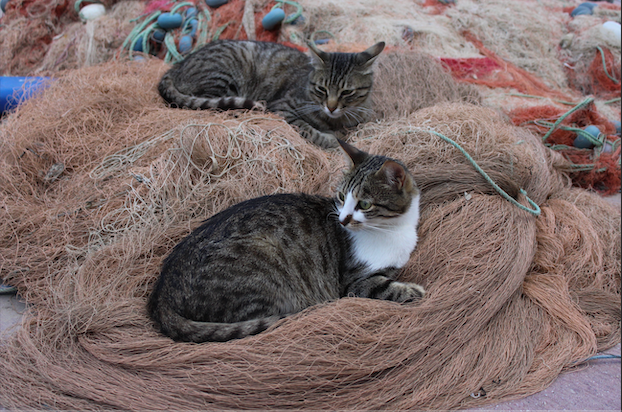

In [5]:
image_2

We can now process the inputs and do inference

In [6]:
inputs = processor(
    images,
    return_tensors='pt'
).to(model.device, model.dtype)

# inference
with torch.no_grad():
    outputs = model(**inputs)

In [7]:
outputs

SuperPointKeypointDescriptionOutput(loss=None, keypoints=tensor([[[0.0437, 0.0167],
         [0.0688, 0.0167],
         [0.0172, 0.0188],
         ...,
         [0.4656, 0.9812],
         [0.5984, 0.9812],
         [0.6953, 0.9812]],

        [[0.0750, 0.0167],
         [0.1266, 0.0167],
         [0.6797, 0.0167],
         ...,
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]]]), scores=tensor([[0.0056, 0.0053, 0.0079,  ..., 0.0125, 0.0539, 0.0377],
        [0.0206, 0.0058, 0.0065,  ..., 0.0000, 0.0000, 0.0000]]), descriptors=tensor([[[-0.0321, -0.0349, -0.0226,  ...,  0.0347,  0.0214,  0.1181],
         [ 0.0191,  0.0508, -0.0198,  ...,  0.0230,  0.0610, -0.0131],
         [ 0.0297, -0.0171, -0.1183,  ..., -0.0772,  0.1020,  0.0317],
         ...,
         [-0.0919, -0.0969, -0.1230,  ...,  0.0871, -0.0199, -0.0314],
         [-0.0563,  0.0221,  0.0102,  ..., -0.0484,  0.0080, -0.0422],
         [-0.0528,  0.0602,  0.0016,  ..., -0.0675, -0.0755, -0.0157

The model output has relative keypoints, descriptors, masks, and scores for each item in the batch.

To plot actual keypoints in the image, we need to post-process the output. We have to pass the actual image sizes to `post_process_keypoint_detection` along with outputs:

In [9]:
image_sizes = [(image.size[1], image.size[0]) for image in images]

outputs = processor.post_process_keypoint_detection(
    outputs,
    image_sizes
)

In [10]:
outputs

[{'keypoints': tensor([[ 226,   57],
          [ 356,   57],
          [  89,   64],
          ...,
          [2413, 3391],
          [3102, 3391],
          [3604, 3391]], dtype=torch.int32),
  'scores': tensor([0.0056, 0.0053, 0.0079, 0.0486, 0.0920, 0.0983, 0.0226, 0.0077, 0.0110,
          0.0566, 0.0314, 0.0113, 0.0063, 0.2112, 0.4752, 0.0350, 0.1834, 0.0131,
          0.0548, 0.0199, 0.0145, 0.3840, 0.2232, 0.0229, 0.0105, 0.0862, 0.0138,
          0.1656, 0.0078, 0.0134, 0.0890, 0.0399, 0.0070, 0.0361, 0.0071, 0.0072,
          0.2160, 0.0052, 0.0071, 0.0877, 0.0072, 0.0393, 0.1161, 0.0090, 0.0134,
          0.0494, 0.0457, 0.1565, 0.0294, 0.0115, 0.0495, 0.1474, 0.1317, 0.0378,
          0.3300, 0.0057, 0.0083, 0.0550, 0.2331, 0.1511, 0.4652, 0.0057, 0.4647,
          0.0665, 0.0239, 0.0130, 0.0690, 0.3644, 0.0097, 0.0305, 0.0090, 0.2469,
          0.2257, 0.0166, 0.0061, 0.0398, 0.0065, 0.0547, 0.2464, 0.0657, 0.0078,
          0.0568, 0.0488, 0.3280, 0.4904, 0.4137, 0.0242, 0

Now the outputs are a list of dictionaries where each dictionary is a processed output of keypoints, scores, and descriptors.

We can use these to plot the keypoints:

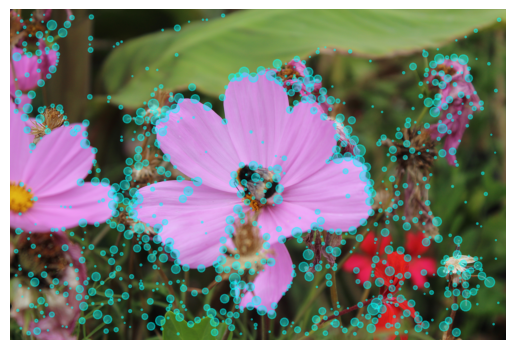

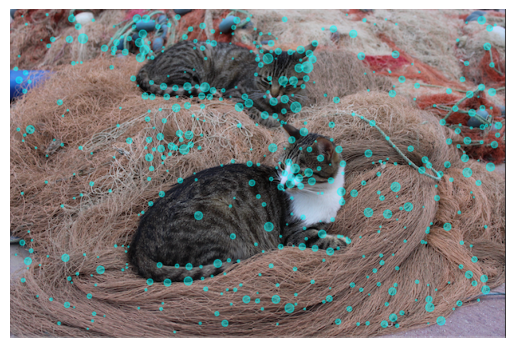

In [16]:
import matplotlib.pyplot as plt
import torch

for i in range(len(images)):
    keypoints = outputs[i]['keypoints'].numpy()
    scores = outputs[i]['scores'].detach().numpy()
    descritpors = outputs[i]['descriptors'].numpy()

    image = images[i]
    image_width, image_height = image.size

    plt.axis('off')
    plt.imshow(image)
    plt.scatter(
        keypoints[:, 0],
        keypoints[:, 1],
        s=scores * 100,
        c='cyan',
        alpha=0.4
    )
    plt.show()